把Zillow輸出成Horizon Net資料格式。
剛上一版差在此腳本會trim掉門框過小的annotation，保留其他的。 (上一版版本是整筆刪掉)

In [1]:
from config import *
from wdoUtils import *
def wdo_3D2pixel_list_withbc(wdo_bbox_3D_list, wdo_bbox_pixel_list):
    has_cross_image =[]
    depths=[]
    for wdo_bbox_3D in wdo_bbox_3D_list:
        wdo_bbox_pixel = []
        pixs , d = wdo_3D2pixel_withbc(wdo_bbox_3D, wdo_bbox_pixel , depths)
        print()
        wdo_bbox_pixel_list.append(wdo_bbox_pixel[:-1])

        #檢查跨越影像的門框. 跟門框中心點對比
        pixs= np.array(pixs)
        bbox = pixs[:-1]
        
        min = bbox.min()
        max = bbox.max()
        check_point = pixs[-1]        

        if(min < check_point < max):
            has_cross_image.append(False)
        else:
            has_cross_image.append(True)
        
    return has_cross_image , depths


# for pano only
def wdo_3D2pixel_withbc(wdo_bbox_3D, wdo_bbox_pixel , depths):
    horizontal_start = np.array([0, -1, 0])
    vertical_start = np.array([0, 0, 1])
    pixs=[]
    # get door pixel coordinates in pano    
    top_center_3d = (np.array(wdo_bbox_3D[0])+  np.array(wdo_bbox_3D[1]))/2
    wdo_bbox_3D_check = list(wdo_bbox_3D.copy())
    wdo_bbox_3D_check.append(top_center_3d)

    # project onto xy plane 
    np_bbox_3d = np.array(wdo_bbox_3D)     
    
    d =  np.linalg.norm(np_bbox_3d[:,],axis=1)   
    depths.append(d)
    
    #for point in wdo_bbox_3D:
    for point in wdo_bbox_3D_check:            
        tmp_horizontal = np.array([point[0], point[1], 0])
        horizontal_theta = getTheta(tmp_horizontal, horizontal_start)
        if point[0] > 0:
            horizontal_theta *= -1        
            
        vertical_theta = getTheta(point, vertical_start)
        horizontal_pixel = getPixel(horizontal_theta, 360, 2048)
        if point[0] > 0:
            horizontal_pixel += 2048

        pixs.append(horizontal_pixel)
        
        vertical_pixel = getPixel(vertical_theta, 180, 1024)
        tmp_np = np.around(np.array([horizontal_pixel, vertical_pixel]).astype(np.float32), decimals=2)
        wdo_bbox_pixel.append(tmp_np.tolist())
    return pixs , depths


In [2]:
import numpy as np
#Sort points by bbox
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def uv_to_polygons(us,vs):
    polys =[]
    for u,v in zip(us,vs):
        box = (
            (u[0],v[0]) ,
            (u[1],v[2]) ,
            (u[1],v[3]) ,
            (u[0],v[1]) ,
        )
        
        polys.append(box)
    return polys


In [6]:
import json
#from wdoUtils import *
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
import random
import cv2
import os

def MakeData( src_file , mode ="train" , img_folder="" , max_count = -1 , remove_small =True , remove_cross =True  , debug_visualize_rate = 3 ):

    #Read data to pano coordinates:
    annotation_list = []
    categories_list = []
    all_images_list=[]
    images_list = []
    persp_img_num = 0
    door_num = 0

    debug_it=2
    all_predict_result=[]
    processed_data_counter = 0
    empty_count = 0
    #================================================
    #                 Parameters
    #================================================
    REMOVE_SMALL= remove_small
    SMALL_WIDTH_THRESHOLD = 0.01
    SMALL_HEIGHT_THRESHOLD = 0.01
    REMOVE_CROSS= remove_cross
    REMOVE_EMPTY = True
    SAMPLE_RATE = debug_visualize_rate
    MAX_DATA_COUNT = max_count

    img_h = 0


    #for room_number in part['test']:    
    for room_number in src_file[mode]:        
        max_door_area = 0
        room_number = int(room_number)   

        src_path = os.path.join( img_folder , '{0:04d}'.format(room_number) )
        json_path = os.path.join(src_path , 'zind_data.json' )
        #Read Data from Zillow 
        with open(json_path, 'r') as f: 
            label = json.load(f)
            #parse_zind_data(label , src_path , room_number)
            for floor_list in label['merger']:
                print(f'floor {floor_list}')
                for complete_room_list in label['merger'][floor_list]:
                    print(f'complete room {complete_room_list}')
                    
                    it_count =0
                    for partial_room_list in label['merger'][floor_list][complete_room_list]:
                        print(f'partial room {partial_room_list}')       

                        for pano_list in label['merger'][floor_list][complete_room_list][partial_room_list]:
                            it_count+=1

                            # debug 採樣用
                            show_sample = random.randint(0, SAMPLE_RATE) == 1

                            #print(f'pano  {pano_list}')
                            pano_name = floor_list + '_' + partial_room_list + '_' + pano_list
                            pano_src_partial = label['merger'][floor_list][complete_room_list][partial_room_list][pano_list]['image_path']
                            pano_src = src_path + '/' + pano_src_partial
                            pano_src_partial = '{0:04d}'.format(room_number) + '/' + pano_src_partial

                            
                            if img_h ==0:
                                input_Img = cv2.imread(pano_src)
                            #wdo_vertices = label['merger'][floor_list][complete_room_list][partial_room_list][pano_list]['layout_raw']['doors']
                            try:
                                wdo_vertices = label['merger'][floor_list][complete_room_list][partial_room_list][pano_list]['layout_visible']['doors']
                            except:
                                wdo_vertices=[]
                            if(REMOVE_EMPTY and len(wdo_vertices)==0):
                                empty_count+=1
                                print(pano_src + " is Empty")
                                continue
                            
                            #all_predict_result[pano_src_partial]=[]             
                            #----------- Get complete pano mask --------------------
                            wdo_bbox_3D_list = wdo_vertices23D(wdo_vertices)
                            wdo_bbox_pixel_list =[]
                            has_cross_imgs , depths = wdo_3D2pixel_list_withbc(wdo_bbox_3D_list , wdo_bbox_pixel_list)
                            
                            if img_h ==0:
                                img_h,img_w , c = input_Img.shape                            
                                             
                            sticks=[]
                            u_list =[]
                            
                            #For each door anno in the image:
                            #elp =np.array([1e-3 , 0])# 避免過窄的門框x offset為0
                            for i, door in enumerate( wdo_bbox_pixel_list):                            
                                do_log = True
                                door = np.array(door)
                                sorted_door = order_points(door)
                                
                                if(has_cross_imgs[i]):                            
                                    sorted_door = np.array([ sorted_door[1] , sorted_door[0] , sorted_door[3], sorted_door[2]])
                                    sorted_door[1]+=[2048 , 0]
                                    sorted_door[2]+=[2048 , 0]                                
                                    center = (sorted_door[0] + sorted_door[2])/2 
                                    #bbox = np.array([sorted_door[0] , sorted_door[2]+elp ]) /[2048,1024]                                
                                    bbox = np.array([sorted_door[0] , sorted_door[2]  ]) /[2048,1024]                                
                                    bbox = bbox.flatten().tolist()
                                    pass                         
                                else:                                                            
                                    door_min = sorted_door[0]
                                    door_max = sorted_door[2]                            
                                    center = np.array( (door_min + door_max)/2)
                                    #bbox = np.array([door_min, door_max  +elp ]) /[2048,1024]                                
                                    bbox = np.array([door_min, door_max  ]) /[2048,1024]                                
                                    bbox = bbox.flatten().tolist()
                                
                                # [過濾] 遇到就直接跳過整筆
                                if (REMOVE_CROSS):
                                    if True in has_cross_imgs:                                    
                                        do_log=False
                                        #break
                                if (REMOVE_SMALL):
                                    #高度限制
                                    if (bbox[3] - bbox[1] < SMALL_HEIGHT_THRESHOLD) :
                                        do_log=False
                                        #break
                                    #寬度限制
                                    if (bbox[2] - bbox[0] <SMALL_WIDTH_THRESHOLD) :
                                        do_log=False
                                        #break

                                # [ Debug 畫點 ]    
                                if(show_sample):
                                    cv2.circle(input_Img, np.int32(center), 15,(255,0,255) , thickness= -1)
                                    for p in door:              
                                        textPose= np.round(p , 2)
                                        #cv2.putText(input_Img , f'{textPose[0]}, {textPose[1]}' , np.int32(p) ,cv2.FONT_HERSHEY_SIMPLEX , 2 ,0.1,cv2.LINE_AA )
                                        cv2.circle(input_Img, np.int32(p), 15,(0,0,255) , thickness= -1)

                                # 主要輸出邏輯 + [轉 0~1 ]    
                                if(not do_log):
                                    print(f"Skip {src_path} {bbox}" )
                                    continue
                                else:
                                    #print(f"Save width {bbox[2] - bbox[0] }")
                                    pass
                                
                                uv = sorted_door / [img_w , img_h ]
                                
                                # 兩兩一組                                                                
                                flatten_u = uv[:,0].reshape(-1)                                
                                flatten_v = uv[:,1].reshape(-1)                                                                                                                                

                                stick = np.concatenate( (
                                            np.concatenate((flatten_v[::4] ,flatten_v[3::4] )), 
                                            np.concatenate((flatten_v[1::4] ,flatten_v[2::4] )))
                                )
                                
                                sticks.append(stick)

                                _u = np.concatenate( 
                                    (flatten_u[::4] ,flatten_u[2::4] )
                                )                                                                
                                u_list.append(_u)                                


                            #若無資料
                            if(len(u_list)<1):
                                continue
                            
                            #移除重複的                            
                            u_list = np.array(u_list)
                            sticks = np.array(sticks)
                            pair,idx = np.unique(u_list, axis=0 , return_index=True)
                            u_list = pair
                            sticks = sticks[idx]

                            # [Testify]
                            if(show_sample):
                                polys = uv_to_polygons( u_list , sticks )                                    
                                for poly in polys:
                                    poly = np.array(poly)  * [img_w , img_h ]  
                                    input_Img = cv2.polylines(input_Img, np.int32([poly]) , True, (255,255,0),5)  

                            all_predict_result.append({
                                "image": pano_src_partial,
                                'u':np.array(u_list).tolist(),
                                'sticks_v':np.array(sticks).tolist(), #每個點的v軸座標，[n,4]

                            })                        

                            if(show_sample):
                                plt.imshow(input_Img)
                                plt.show()
                            processed_data_counter+=1
                            if MAX_DATA_COUNT >0 and processed_data_counter >=MAX_DATA_COUNT:                            
                                return all_predict_result

                            '''
                            #print(wdo_bbox_pixel_list)                            
                            print(processed_data_counter)
                            if processed_data_counter >5:
                                break
                        break
                    break
                break
            break
        break
                            '''
    
    print("empty count" , empty_count)
    return all_predict_result

In [4]:
# Load Ground Truth Pano Data.
#Zind資料分區，包含train , test, val組合
partation_path = ZILLOW_ZIND_JSON_PATH
with open(partation_path, 'r') as file:
    part = json.load(file)

print(len(part['test']))  # Folder count

# Test 
#data =MakeData(src_file= part , img_folder= ZILLOW_DATASET_FOLDER)

158


floor floor_01
complete room complete_room_02
partial room partial_room_02

complete room complete_room_03
partial room partial_room_03

complete room complete_room_04
partial room partial_room_07

complete room complete_room_05
partial room partial_room_08


complete room complete_room_06
partial room partial_room_10




complete room complete_room_01
partial room partial_room_09



Skip F:/THU/DoorSeg/OneDrive_2023-01-07/Door_Detection/data/data\0919 [0.3609277307987213, 0.4691113233566284, 0.3677392601966858, 0.5709375143051147]
partial room partial_room_06

partial room partial_room_04




partial room partial_room_05



Skip F:/THU/DoorSeg/OneDrive_2023-01-07/Door_Detection/data/data\0919 [0.7892382740974426, 0.4038378894329071, 0.7892382740974426, 0.7056933641433716]
partial room partial_room_01


floor floor_02
complete room complete_room_02
partial room partial_room_02

partial room partial_room_03


complete room complete_room_03
partial room partial_room_04

complete room com

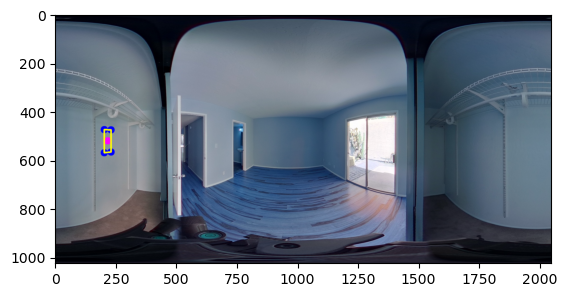



Skip F:/THU/DoorSeg/OneDrive_2023-01-07/Door_Detection/data/data\1470 [0.36500489711761475, 0.4761914014816284, 0.3702636659145355, 0.5365331768989563]



Skip F:/THU/DoorSeg/OneDrive_2023-01-07/Door_Detection/data/data\1470 [0.35518065094947815, 0.47254884243011475, 0.3608154356479645, 0.54248046875]





Skip F:/THU/DoorSeg/OneDrive_2023-01-07/Door_Detection/data/data\1470 [0.515820324420929, 0.4620410203933716, 0.515820324420929, 0.5693749785423279]





Skip F:/THU/DoorSeg/OneDrive_2023-01-07/Door_Detection/data/data\1470 [0.6079785227775574, 0.44965821504592896, 0.6168798804283142, 0.5794140696525574]
Skip F:/THU/DoorSeg/OneDrive_2023-01-07/Door_Detection/data/data\1470 [0.5962353348731995, 0.45146483182907104, 0.5962353348731995, 0.5888085961341858]
Skip F:/THU/DoorSeg/OneDrive_2023-01-07/Door_Detection/data/data\1470 [0.4617382884025574, 0.47016602754592896, 0.4692040979862213, 0.545849621295929]






Skip F:/THU/DoorSeg/OneDrive_2023-01-07/Door_Detection/data/data\1470 [0.48

In [10]:
data =MakeData(src_file= part , img_folder= ZILLOW_DATASET_FOLDER , mode='train' ,max_count=10000  , debug_visualize_rate=5000 , remove_cross=False )
json_path = os.path.join(os.getcwd(), 'anno', 'train_visiable_10k.json') 
with open(json_path, "w") as outfile:
    json.dump(data, outfile)
'''
''' 
print(len(data))

In [37]:
# Write Processed Zind Data.
import json
import os
#json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_complete.json')
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_complete_10.json')
#json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_complete_10.json')
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_complete_10-v1.json')
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_complete_10-fixedv1.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_complete_10-fixedv2.json')
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_big_doors.json')
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_complete_all.json')

#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_all.json') # 0610 ALL
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_all_noEmpty.json') # 0610 ALL
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_small.json')

data =MakeData()
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_noramll_200.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_noramll_200.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_all1.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_all1.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_200_no_cross.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_16_no_cross.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_horizon_big_10.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_horizon_big_unique2k.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_horizon_normalbig_all.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_horizon_w0.01_2k.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_horizon_w0.01_200.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_horizon_unique_w0.01_all.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_horizon_unique_w0.01_all.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_horizon_unique_w0.01_all_fixedbug.json') 
json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_horizon_unique_w0.01_20_fixedbug.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_horizon_unique_w0.01_20_fixedbug.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_horizon_unique_w0.01_all_fixedbug.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_horizon_normalbig_unique2k.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_horizon_big_unique200.json') 
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_horizon_unique_all.json') 
with open(json_path, "w") as outfile:
    json.dump(data, outfile)
'''
''' 
print(len(data))

floor floor_01
complete room complete_room_02
partial room partial_room_02
pano  pano_35
f:\THU\DoorSeg\OneDrive_2023-01-07\Door_Detection\data/data/0919/panos/floor_01_partial_room_02_pano_35.jpg

Save width 0.49495117366313934
complete room complete_room_03
partial room partial_room_03
pano  pano_25
f:\THU\DoorSeg\OneDrive_2023-01-07\Door_Detection\data/data/0919/panos/floor_01_partial_room_03_pano_25.jpg

Save width 0.3482128828763962
complete room complete_room_04
partial room partial_room_07
pano  pano_40
f:\THU\DoorSeg\OneDrive_2023-01-07\Door_Detection\data/data/0919/panos/floor_01_partial_room_07_pano_40.jpg

Save width 0.10517087578773499
complete room complete_room_05
partial room partial_room_08
pano  pano_11
f:\THU\DoorSeg\OneDrive_2023-01-07\Door_Detection\data/data/0919/panos/floor_01_partial_room_08_pano_11.jpg


Save width 0.028666973114013672
Save width 0.2282128930091858
complete room complete_room_06
partial room partial_room_10
pano  pano_29
f:\THU\DoorSeg\OneDrive_

# Generate Coco Data

In [ ]:

import json
import os
# Prepaire default coco data:
coco_data = get_default_coco()

#load json
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_complete_10.json')
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_complete_all.json')
#json_path = os.path.join(os.getcwd(), 'output', 'train_visiable_complete_10.json')
json_path = os.path.join(os.getcwd(), 'output', 'test_visiable_complete_10.json')
f= open(json_path)
visiable_door_anno = json.loads(f.read())
f.close()

In [ ]:
import matplotlib.pyplot as plt 
print(visiable_door_anno[0].keys())
ind =1
print(visiable_door_anno[ind]['cross_img'])
print(visiable_door_anno[ind]['3d_pos'])
img_path = os.path.join(os.getcwd() , "data/data/", visiable_door_anno[ind]['image'])
img = cv2.imread(img_path)
plt.imshow(img)
plt.show

# 檔案處理

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 

img_anno_list = []
kp_anno_list=[]
it=0
#for data in visiable_door_anno[40:43]:
for data in visiable_door_anno[:]:
    img_path = os.path.join(os.getcwd() , "data/data/", data['image'])
    img = cv2.imread(img_path)
    h,w,_ = img.shape
    #plt.imshow(img)
    #plt.show()

    img_anno ={
        "license": 6,
		"file_name": data['image'],
		"height": h,
		"width": w,
		#"coco_url": "http://images.cocodataset.org/val2017/000000153669.jpg",
		#"date_captured": "2013-11-19 19:44:15",
		#"flickr_url": "http://farm5.staticflickr.com/4023/4659511777_06fdc54df9_z.jpg",
		"id": it
    }
    img_anno_list.append(img_anno)
    anno = {
        'segmentations':[],
        'num_keypoints':0,
        "area": [],
        "iscrowd": 0,
        "keypoints": [],
        "image_id": it,
        "bbox": [],
        "category_id": 1,
        "labels": 1,
        "id": it,        
    }
    #-------------- [Fill in anno] -----------------    
    # 複數的門
   
    
    #-------------- [Fill in anno] -----------------    
    # sort 2D points
    doors_2d = np.array(data['2d_pos'])   
    door_segs=[]
    door_kps=[]

    min_bbox_x=9999
    min_bbox_y=9999
    max_bbox_x=0
    max_bbox_y=0
    #for door in doors_2d:                    
    for i, door in enumerate(doors_2d):                    
        #data_2d = np.array( doors)
        #sort_data = order_points(door)  
        door = order_points(door)  

        # Flip door if cross image
        #anno['hasCross'] = data['cross_img'][i]
        seg = {
            "cross_img":data['cross_img'][i],
            "segmentation":[]
        }
        
        if(data['cross_img'][i]):
            # Area:
            area = float( abs( door[0][0]*(door[0][1] - door[3][1])) + abs( (2048-door[1][0])*(door[1][1] - door[2][1])))
            anno['area'].append(area)
            # Flip door order
            door_copy = door.copy()
            door[0],door[1],door[2],door[3] = door_copy[1],door_copy[0],door_copy[3],door_copy[2] 
            #bbox = biggest boarder  format:[x1, y1, x2, y2]            
            #anno['bbox'].append([0 , door[0][1] , 2047 , door[2][1]])  #This is Wrong!            

                   
        else:
            area =float( abs(door[1][0]-door[0][0]) * abs(door[2][1]-door[0][1]) )
            anno['area'].append(area)
            #anno['bbox'].append([min_bbox_x , min_bbox_y , max_bbox_x , max_bbox_y])
            #anno['bbox'].append([door[0][0] , door[0][1] , door[2][0] , door[2][1]])
            

        door_count , point_count ,xy= doors_2d.shape
        temp = np.array( [np.tile( np.array([0,0,2]) , (point_count,1))]*door_count)
        temp[:,:,0:2] = doors_2d[:,:,0:2]        

        #keypoints=[[door[0,:],2] , [door[1,:],2] , [door[2,:],2] , [door[3,:],2] ]

        keypoints = temp.tolist()
        door=door.tolist()

        #紀錄資料
        #door_segs.append([door[0],door[1],door[2],door[3]])  # TODO:取代
        seg['segmentation']= [door[0],door[1],door[2],door[3]]
        door_segs.append(seg)
        door_kps.append(keypoints)


        #[DEBUG] Plot all point in order
        i=0
        for point in door:            
            point= np.array(point)
            cv2.circle(img,center=point.astype(int) , radius=25 , color=(255,0,0), thickness=-1)
            cv2.putText(img , text=str(i) , org=point.astype(int) ,  fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=5.0,
                color=(0, 255, 0),
                thickness=2,
                lineType=cv2.LINE_4)
            i+=1  

    #算bbox
    x,y = (min_bbox_x) ,(min_bbox_y)     
    bbox_w , bbox_h = max_bbox_x - min_bbox_x , abs(max_bbox_y- min_bbox_y)
    anno['labels']=1
    #anno['bbox'] = np.array(anno['bbox'] ).tolist()    
    anno['keypoints'] = np.array(door_kps).flatten().tolist()
    #anno['segmentation'] = np.array(door_segs).reshape((-1,8)).tolist()    
    anno['segmentations'] = door_segs

    #結算本筆data
    kp_anno_list.append(anno)

    it+=1
    #plt.imshow(img)
    #plt.show()
coco_data['annotations'] = kp_anno_list
coco_data['images'] = img_anno_list
print(coco_data)



In [ ]:
#寫出檔案
#json_out_path = os.path.join(os.getcwd(),"output","keypoint_coco_v_0-100.json")
#json_out_path = os.path.join(os.getcwd(),"output","keypoint_coco_v_0-300.json")
#json_out_path = os.path.join(os.getcwd(),"output","keypoint_coco_v3-10.json")
json_out_path = os.path.join(os.getcwd(),"output","keypoint_coco_test_v1-10.json")
json_obj = json.dumps(coco_data )
with open(json_out_path , 'w') as output:
    output.write(json_obj)


# 視覺化

In [ ]:
from detectron2.data.datasets import register_coco_instances
import os
train_dataset_name = "test_v8"
train_images_path = os.path.join(os.getcwd() , "data/data/")
#train_json_annot_path = os.path.join(os.getcwd() , "output","keypoint_coco_v1.json")
#train_json_annot_path = os.path.join(os.getcwd() , "output","keypoint_coco_v1_0-300.json")
train_json_annot_path = os.path.join(os.getcwd() , "output","train_visiable_small.json")

#註冊資料集
register_coco_instances(name=train_dataset_name , metadata={} , json_file=train_json_annot_path , image_root= train_images_path)


In [ ]:
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
import torch, detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import random
import cv2
import matplotlib.pyplot as plt 

#視覺化
#--- 以下程式碼缺少bbox，不能跑 ---
def plot_samples(dataset_name , n=2 ):
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)
    
    for s in random.sample(dataset_custom,n):
        print( 'fileName ',s['file_name'])
        print(s.keys())
        print(s['annotations'])
        #img_path = os.path.join( os.getcwd(),"data/data/",os.path.basename( s['file_name']))
        img_path =s['file_name']
        img = cv2.imread(img_path) #cv load in BGR format
        print(img_path)
        v = Visualizer(img[:,:,::-1] , metadata=dataset_custom_metadata , scale=0.5) #deteron2 need RGB format. use ::-1 to swap red and blue channel
        v = v.draw_dataset_dict(s)
        #out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize=(10,15))
        plt.imshow(v.get_image())
        plt.show()

print( DatasetCatalog.get(train_dataset_name))
plot_samples(train_dataset_name )

### 有些門的標記點看起來歪歪的，檢查是不是原始資料問題?

# Train

In [44]:
import numpy as np
import scipy.ndimage
a = np.array([0.1,0.5,0.3,0.5,0.1,0.9 ,1])
max_v = scipy.ndimage.maximum_filter(a, size=3, mode='wrap', min=0.4)
print (max_v)

idx = np.where(max_v == a)[0]
print(idx)

TypeError: maximum_filter() got an unexpected keyword argument 'min'